In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

## Data

In [2]:
# Descargar datos históricos para Apple (AAPL)
ticker = 'NVDA'
data = yf.download(ticker, start='2021-01-01', end='2024-10-13')

# Preparación de la serie temporal
df = data[['Open', 'Close', 'Low', 'High']]
df

[*********************100%%**********************]  1 of 1 completed


,Open,Close,Low,High
Date,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500
2021-01-05,13.099750,13.404750,13.087000,13.443500
2021-01-06,13.222500,12.614500,12.586000,13.245000
2021-01-07,12.967500,13.344000,12.886500,13.377750
2021-01-08,13.362500,13.276750,13.042000,13.421000
...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999
2024-10-08,130.259995,132.889999,129.419998,133.479996
2024-10-09,134.110001,132.649994,131.380005,134.520004


In [3]:
openData = df.Open.values.astype('float32')

total_rows = openData.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

XTrain = openData[:train_end]
XValidation = openData[train_end:validation_end]
XTest = openData[validation_end:]

print("Training set size:", len(XTrain), f"({len(XTrain)/len(openData)*100}%)")
print("Validation set size:", len(XValidation), f"({len(XValidation)/len(openData)*100}%)")
print("Test set size:", len(XTest), f"({len(XTest)/len(openData)*100}%)")

Training set size: 665 (70.0%)
Validation set size: 190 (20.0%)
Test set size: 95 (10.0%)


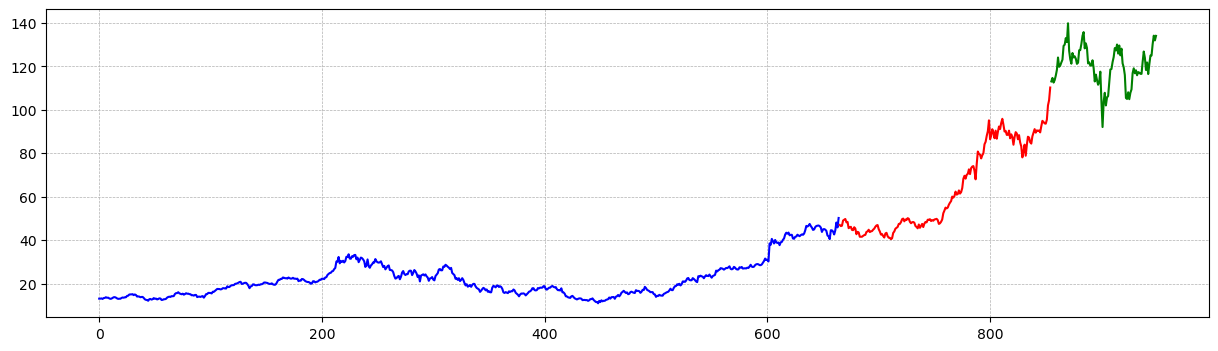

In [4]:
plt.figure(figsize=(15,4))

# plt.plot(openData, color='gray')
plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Processing data

In [5]:
openData.shape

(950,)

In [6]:
openData = openData.reshape(-1,1)
XTrain = XTrain.reshape(-1,1)
XValidation = XValidation.reshape(-1,1)
XTest = XTest.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(openData)

openData = scaler.transform(openData)
XTrain = scaler.transform(XTrain)
XValidation = scaler.transform(XValidation)
XTest = scaler.transform(XTest)

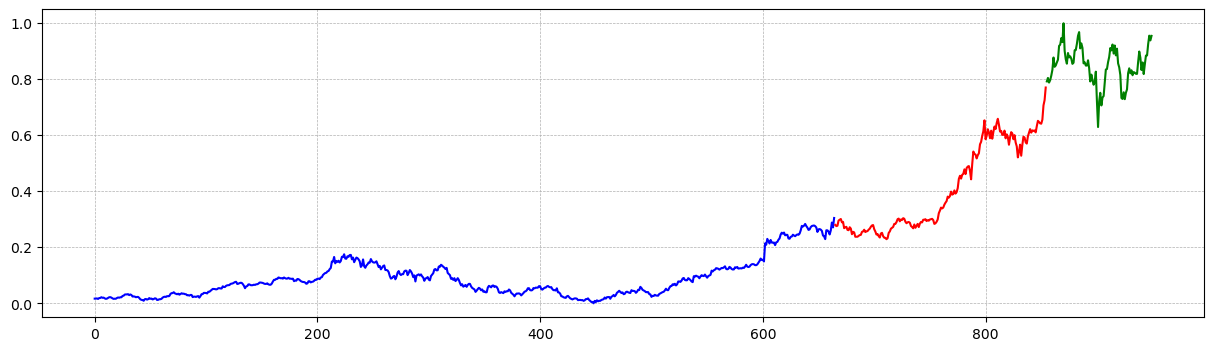

In [7]:
plt.figure(figsize=(15,4))

plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [8]:
def create_lookback(dataset, lookback, device):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        after_window = dataset[i + lookback]
        X.append(window)
        y.append(after_window)
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    return X_tensor, y_tensor

In [9]:
# Dispositivo para entrenamiento (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
lookback = 2
XTrain_tensor, TTrain_tensor = create_lookback(XTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback(XValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback(XTest, lookback, device)

Timeseries_tensor, TTimeseries_tensor = create_lookback(openData, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([663, 2, 1]), 
TTrain_tensor shape: torch.Size([663, 1])

XValidation_tensor shape: torch.Size([188, 2, 1]), 
TValidation_tensor shape: torch.Size([188, 1])

XTest_tensor shape: torch.Size([93, 2, 1]), 
TTest_tensor shape: torch.Size([93, 1])


In [11]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

21
6
3


## LSTM Model

In [19]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

#### Training and Validation

Epoch [5/50] - Training Loss: 0.0041, Validation Loss: 0.1161, Learning Rate: 0.000500
Validation RMSE: 43.373203


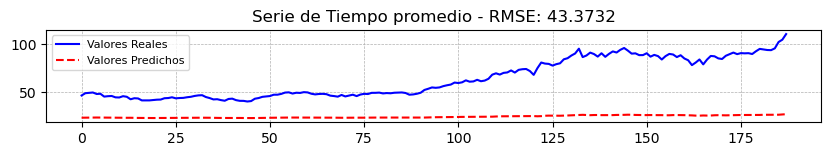


Epoch [10/50] - Training Loss: 0.0030, Validation Loss: 0.0749, Learning Rate: 0.000500
Validation RMSE: 34.830116


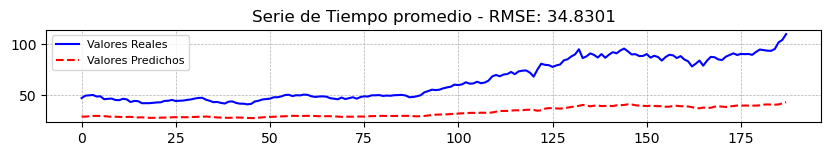


Epoch [15/50] - Training Loss: 0.0007, Validation Loss: 0.0060, Learning Rate: 0.000500
Validation RMSE: 9.832568


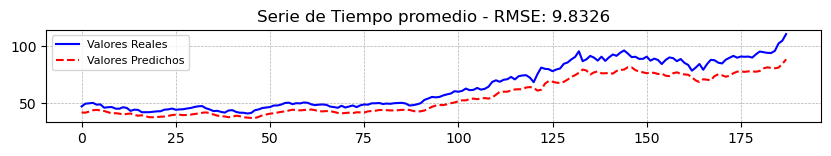


Epoch [20/50] - Training Loss: 0.0003, Validation Loss: 0.0004, Learning Rate: 0.000500
Validation RMSE: 2.5146122


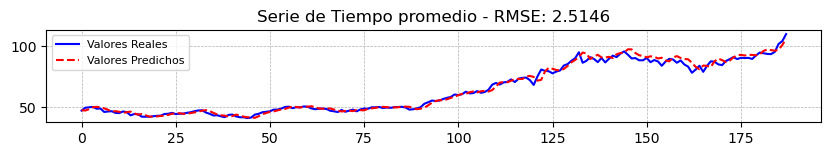


Epoch [25/50] - Training Loss: 0.0002, Validation Loss: 0.0004, Learning Rate: 0.000500
Validation RMSE: 2.4076567


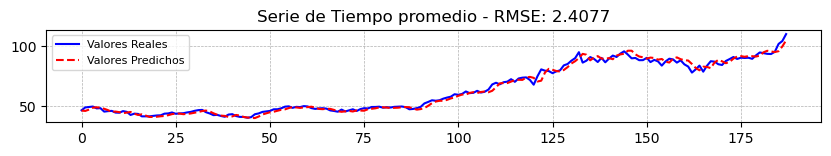


Early stopping! in epoch 29
Training Loss: 0.0002, Validation Loss: 0.0004, Learning Rate: 0.000500
Validation RMSE: 2.4136949     std: 0.0


In [20]:
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn =  nn.MSELoss()
# loss_fn = nn.L1Loss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 50
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  

for epoch in range(n_epochs):

    total_loss = 0.0
    
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() 
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = []
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    # scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)
    observed = np.concatenate(y_observed, axis=0)
    
    predicted = scaler.inverse_transform(predicted)
    observed = scaler.inverse_transform(observed)
    
    rmses = []
    for i in range(predicted.shape[1]):
        rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)

    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", np.std(rmses))

        break
    
    if (epoch+1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Valores Reales', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', color="red")
        plt.title(f'Serie de Tiempo promedio - RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

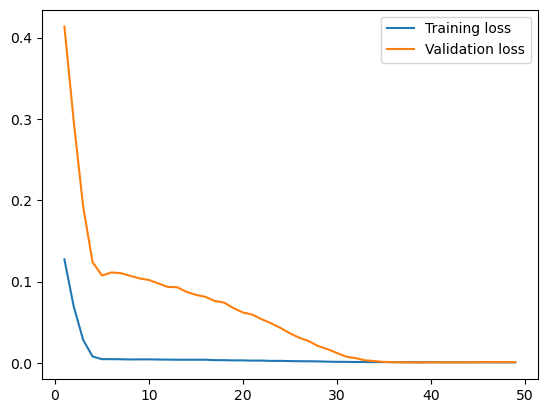

In [14]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

#### Evaluation on test data

Mejor Serie de Tiempo (Serie 1) - RMSE: 10.0493
Peor Serie de Tiempo (Serie 1) - RMSE: 10.0493


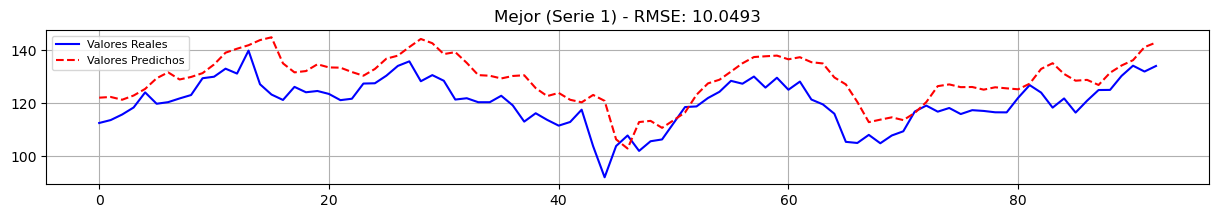

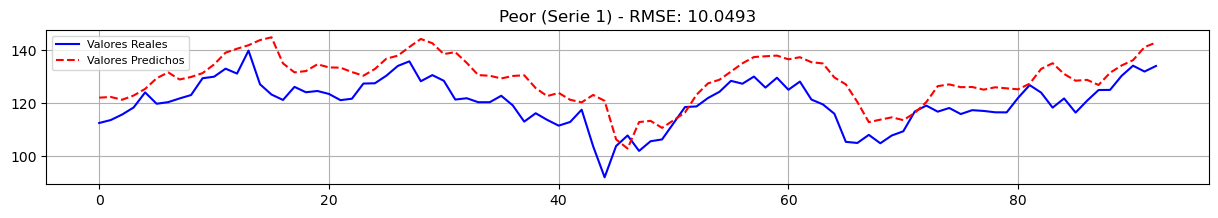

RMSE promedio: 10.049302     std: 0.0


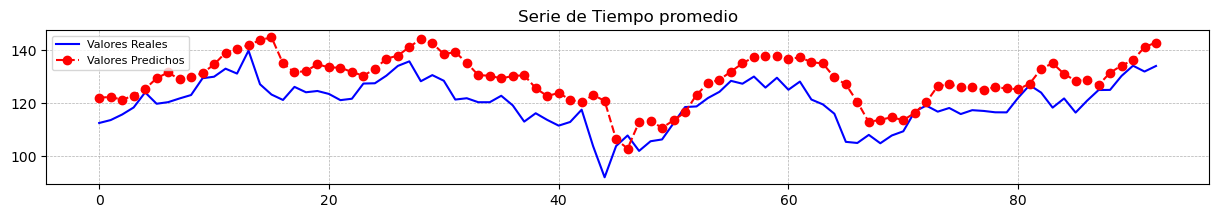

In [15]:
y_predicted = []
y_observed = []

# Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)

        # y_predicted.extend(y_pred.cpu().numpy())
        y_predicted.append(y_pred.cpu().numpy())
        y_observed.append(y_batch.cpu().numpy())

predicted = np.concatenate(y_predicted, axis=0)
observed = np.concatenate(y_observed, axis=0)

predicted = scaler.inverse_transform(predicted)
observed = scaler.inverse_transform(observed)

# Calculamos el RMSE por cada serie de tiempo
rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)

# Mejor y peor RMSE
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print(f'Mejor Serie de Tiempo (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
print(f'Peor Serie de Tiempo (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')

plt.figure(figsize=(15, 2))
plt.plot(observed[:, best_rmse_index], label='Valores Reales', color='blue')
plt.plot(predicted[:, best_rmse_index], label='Valores Predichos', linestyle='--', color="red")
plt.title(f'Mejor (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid()
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(observed[:, worst_rmse_index], label='Valores Reales', color='blue')
plt.plot(predicted[:, worst_rmse_index], label='Valores Predichos', linestyle='--', color="red")
plt.title(f'Peor (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid()
plt.show()

print("RMSE promedio:", np.mean(rmses), "    std:", np.std(rmses))

plt.figure(figsize=(15, 2))
plt.plot(np.mean(observed, axis=1), label='Valores Reales', color='blue')
plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', marker='o', color="red")
plt.title(f'Serie de Tiempo promedio')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

#### All data

Mejor Serie de Tiempo (Serie 1) - RMSE: 3.6634
Peor Serie de Tiempo (Serie 1) - RMSE: 3.6634


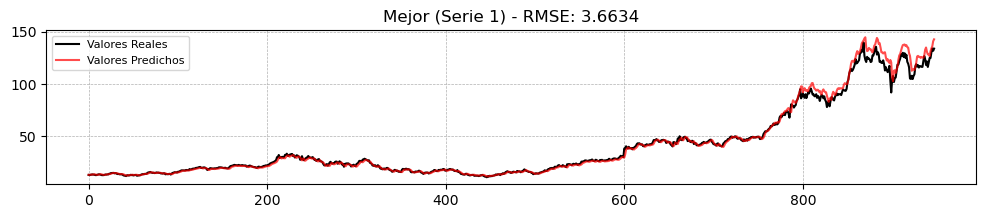

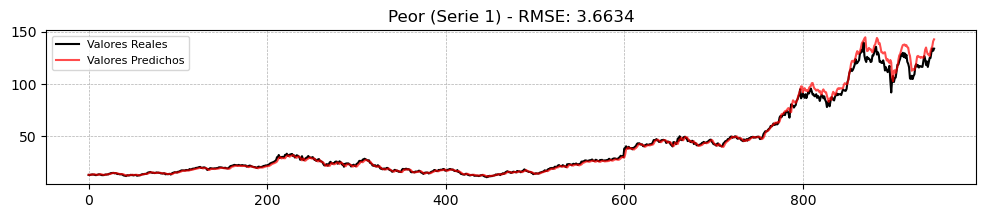

RMSE promedio:  3.6633978


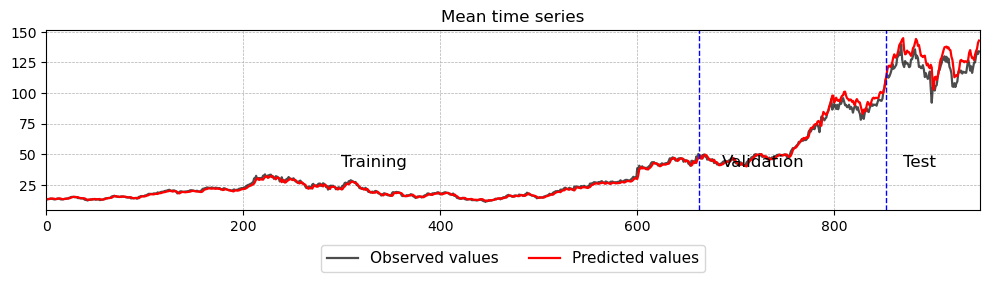

In [16]:
model.eval()
with torch.no_grad():
    y_pred_test = model(Timeseries_tensor)

predicted = scaler.inverse_transform(y_pred_test.cpu().numpy())
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy())

# predicted = y_pred_test.cpu().numpy()
# observed = TTimeseries_tensor.cpu().numpy()

rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)
    
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print(f'Mejor Serie de Tiempo (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
print(f'Peor Serie de Tiempo (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')

plt.figure(figsize=(12, 2))
plt.plot(observed[:, best_rmse_index], label='Valores Reales', color="k")
plt.plot(predicted[:, best_rmse_index], label='Valores Predichos', linestyle='-', color="red", alpha=0.7)
plt.title(f'Mejor (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(observed[:, worst_rmse_index], label='Valores Reales', color="k")
plt.plot(predicted[:, worst_rmse_index], label='Valores Predichos', linestyle='-', color="red", alpha=0.7)
plt.title(f'Peor (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

print("RMSE promedio: ", np.mean(rmses))

plt.figure(figsize=(10, 3))
plt.plot(np.mean(observed, axis=1), color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='-', color="red", linewidth=1.6, alpha=1)
# Líneas punteadas para marcar las divisiones entre las fases
plt.axvline(x=len(XTrain)-lookback, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='blue', linestyle='--', linewidth=1)
# Etiquetas para las fases
plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')
# Ajustar los límites del eje x
plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title(f'Mean time series')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# plt.plot(np.mean(observed, axis=1), label='Real values', color="k")
# plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='-', color="red", alpha=0.7)
# plt.title(f'Mean time series')
# plt.legend(fontsize=8)
# plt.grid(linestyle = '--', linewidth = 0.5)
# plt.show()